# HW1 -- Frank Baring

In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import os

/Users/frankbaring/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Import and display data

In [2]:
# Import data
root = '/Users/frankbaring/documents/Machine_Learning_CBS/Homeworks/Answers/HW3/data/'
os.chdir(root)
data = pd.read_csv("Advertising.csv")
# Remove first column
data = data.iloc[:, 1:]

In [3]:
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


#### Split data

In [4]:
# Split data
np.random.seed(1)
test = data.sample(n=25) # Validation set
test_x = test.drop('sales', axis=1)
test_y = test['sales']

train = data.drop(test.index) # Train set
train_x = train.drop('sales', axis=1)
train_y = train['sales']

#### Scale data: test data and training data are scaled using the mean and standard deviation from the training data.

In [5]:
# Scale
mean = train_x.mean(axis=0)
train_x -= mean
test_x -= mean
std = train_x.std(axis=0)
train_x /= std
test_x -= mean

#### Import additional packages for NN

In [6]:
from tensorflow import keras
from tensorflow.keras.metrics import MeanAbsoluteError
from keras import models
from keras import layers

2023-04-11 14:37:51.663740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Functions

In [7]:
# Fuction to Build Neural Network with a sequence of two hidden layers, which are densely (fully) connected.
# Dropout set to 0.
def build_model(train_data,my_units,dropout = 0): 
  model = models.Sequential()
  model.add(layers.Dense(train_data.shape[1], activation='relu', input_shape=(train_data.shape[1],))) # Input
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(my_units, activation='relu')) #Hidden layer 1
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(my_units, activation='relu')) #Hidden layer 2
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(units = 1)) # Output
  
  model.compile(optimizer='Adam', loss='mse', metrics=['mae']) # Mean Absolute Error for our validation metric
  return model

# Function for K-fold validation to find optimal number of epochs
def k_val_model(my_train_x, my_train_y, max_epochs, units, d = 0, k = 4):
    num_val_samples = len(my_train_x) // k # floor division
    max_epochs = 150
    all_mae_histories_train = []
    all_mae_histories_val = []

    for i in range(k):
      print('processing fold #', i)
      validate_x = my_train_x[i * num_val_samples: (i + 1) * num_val_samples]
      validate_y = my_train_y[i * num_val_samples: (i + 1) * num_val_samples]
      partial_train_x = np.concatenate(
          [my_train_x[:i * num_val_samples],
          my_train_x[(i + 1) * num_val_samples:]],
          axis=0)

      partial_train_y = np.concatenate(
          [my_train_y[:i * num_val_samples],
          my_train_y[(i + 1) * num_val_samples:]],
          axis=0)

      # fit the model 
      model = build_model(train_data = my_train_x,my_units = units, dropout = d) # 2 units in hidden layers
      history = model.fit(partial_train_x, partial_train_y, validation_data=(validate_x, validate_y),
                                                    epochs = max_epochs, batch_size = 1, verbose = 0)
 
      # save the val and train mae values
      mae_history_val = history.history['val_mae'] 
      mae_history_train = history.history['mae']
      all_mae_histories_val.append(mae_history_val)
      all_mae_histories_train.append(mae_history_train)

    # return all val and train mae values
    return(all_mae_histories_train,all_mae_histories_val)

# Function to plot validation metric, training set vs validaion set.
def plot_metric(my_his_train, my_his_val, num_epochs):
    # History of mean K-fold train scores
    average_mae_history_train = [np.mean([x[i] for x in my_his_train]) for i in range(num_epochs)]
    # History of mean K-fold validation scores
    average_mae_history_val = [np.mean([x[i] for x in my_his_val]) for i in range(num_epochs)]
    
    #Plot validation and training scores
    plt.plot(range(1, len(average_mae_history_val) + 1), average_mae_history_val,label = 'validation')
    plt.plot(range(1, len(average_mae_history_train) + 1), average_mae_history_train,label = 'training')
    plt.ylim(0,5)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

## Question 1

#### Two hidden layer neural network to predict sales. 25 observations used as validation set, 150 epochs and no dropout.

In [8]:
#look at the model summary
network = build_model(train_data = train_x,my_units = 2) #dropout = 0
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

2023-04-11 14:37:53.962485: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Run k_val_model function to perform k-fold validation and find optimal number of epochs for our model.

#### k = 4, max epochs = 150

In [9]:
his_train, his_val = k_val_model(train_x, train_y, max_epochs = 150, units = 2, k = 4)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


#### Plot validation metric: MAE

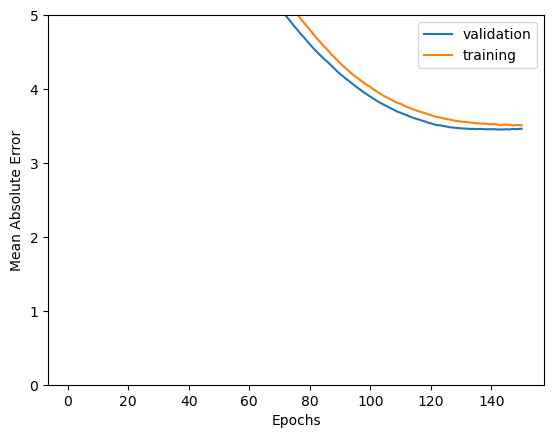

In [10]:
plot_metric(his_train, his_val, num_epochs = 150)

#### Final model with no dropout.

In [11]:
# Import early stopping so that we can find optimal number of epochs (in a range)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', patience = 20)

# Build the model
model1 = build_model(train_data = train_x,my_units = 2)
# Fit the model
model1.fit(train_x, train_y, epochs = 150, validation_split = 0.2, verbose = 0, callbacks=[es])

#### Check performance on test data.

In [12]:
test = model1.evaluate(test_x, test_y, verbose = 0)

print("Mean absolute error on test set for non-dropout model: " + str(round(test[1],2)))

Mean absolute error on test set for non-dropout model: 107.29


## Question 2

#### This neural network has two hidden layers and is fit to a training data set, which consists of 175 observations. The model uses three independent variables -- TV, Radio, Newspaper -- to predict sales. The independent varaibles are scaled before the model is fit. 

#### The model is a weak predictor, despite the validation set performing almost as well as the training set, in terms of mean absolute error (MAE), across all epochs. The minimum MAE for the validation data is reached at around 125 epochs and does not decrease further from there. The mean absolute error achieved on the final model, when evaluated on test data was 107.29. This model used early stopping to optimize, terminating learning at 20 epochs of no improvement (patience = 20). The model is likely lacking in performance on the test data due to insufficient data, given it is only fit on 175 observations across 3 input features. With more model complexity we could expect to see better performance. Another factor to consider is that we were not using dropout, which helps mitigate the danger of overfitting.

#### The input layer has 3 units because, in most cases, the number of units in the input layer should be the same as the number of features in the data (fewer results in loss, more results in overfitting). I decided to include 2 units in each of my hidden layers. This is because it is generally a good rule for the hidden layers to have a number of units that is roughly at the midpoint between the input and output layers. Given that our dataset only has 3 features, it makes sense for the hidden layers to have 2 units each such that the compound features are consolidating information from the input features and not overfitting.

#### The output layer has 1 unit because we are predicting a single value.

## Question 3

#### Add dropout to both layers.

In [13]:
# Look at the model summary for model with dropout, named network_drop
# The dropout value 0.2 is completely arbitrary, we will be testing multiple.
network_drop = build_model(train_data = train_x,my_units = 2,dropout = 0.2)
network_drop.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 3)                 12        
                                                                 
 dropout_18 (Dropout)        (None, 3)                 0         
                                                                 
 dense_25 (Dense)            (None, 2)                 8         
                                                                 
 dropout_19 (Dropout)        (None, 2)                 0         
                                                                 
 dense_26 (Dense)            (None, 2)                 6         
                                                                 
 dropout_20 (Dropout)        (None, 2)                 0         
                                                                 
 dense_27 (Dense)            (None, 1)                

In [14]:
# Dropout valuess to be tested
dropout_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.1


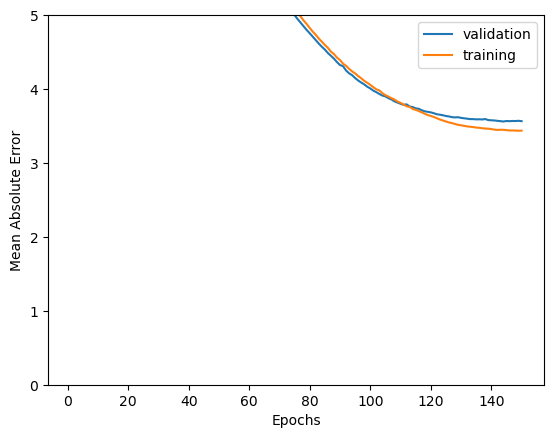

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.2


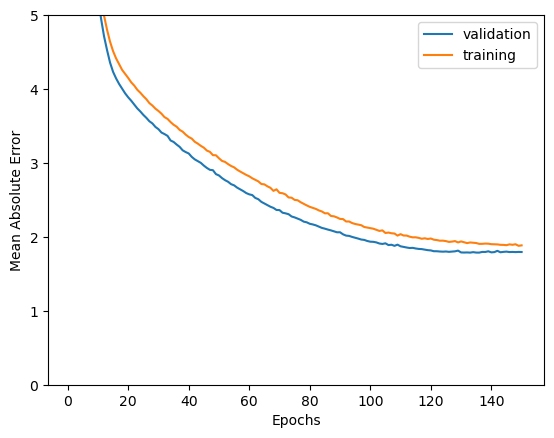

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.3


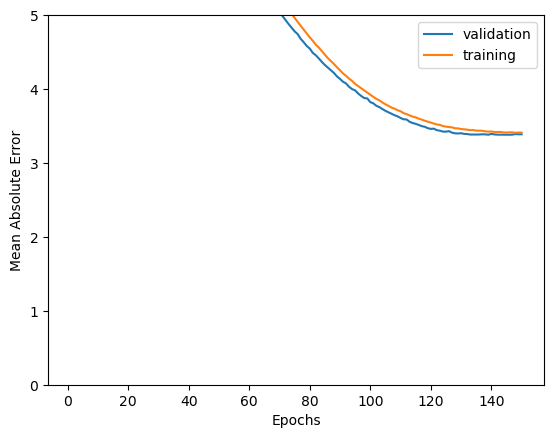

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.4


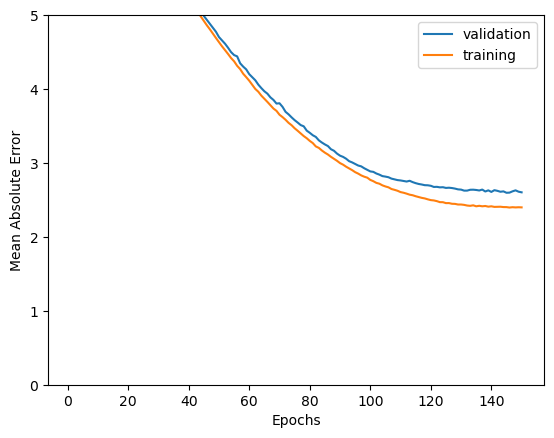

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.5


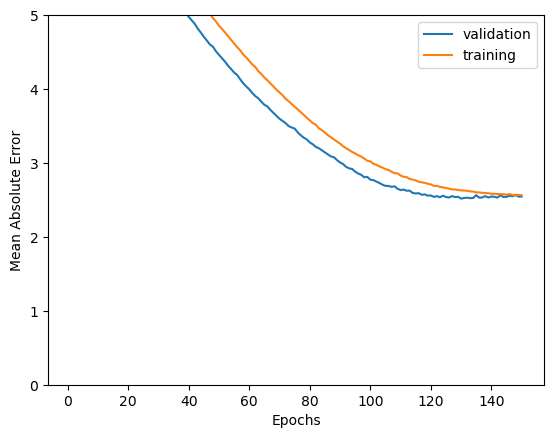

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.6


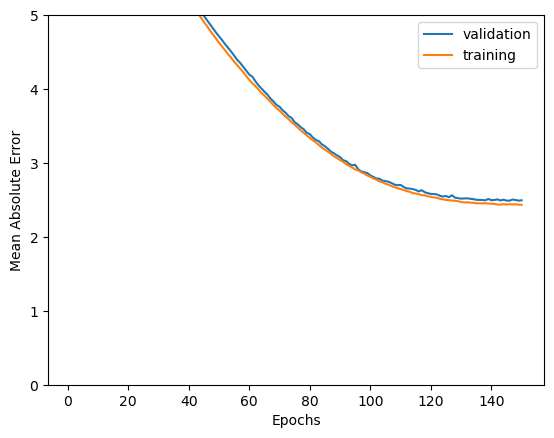

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.7


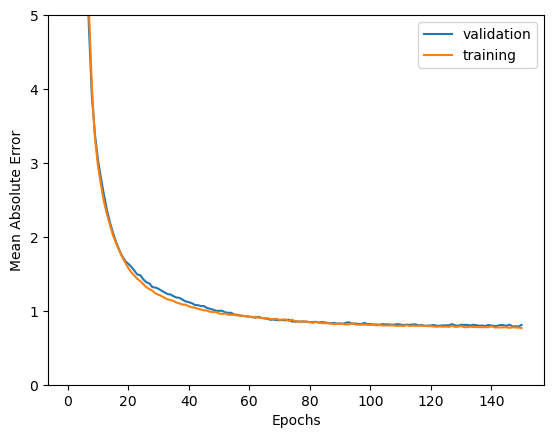

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.8


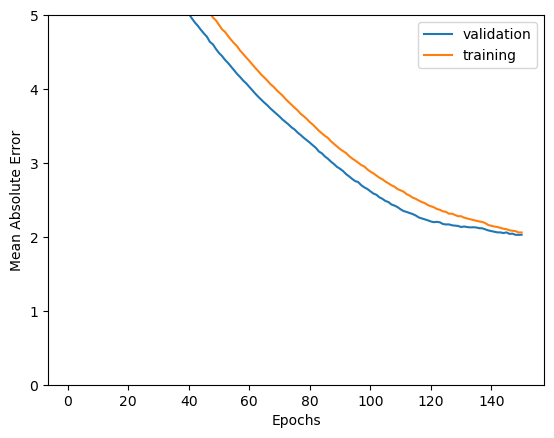

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
Dropout probability: 0.9


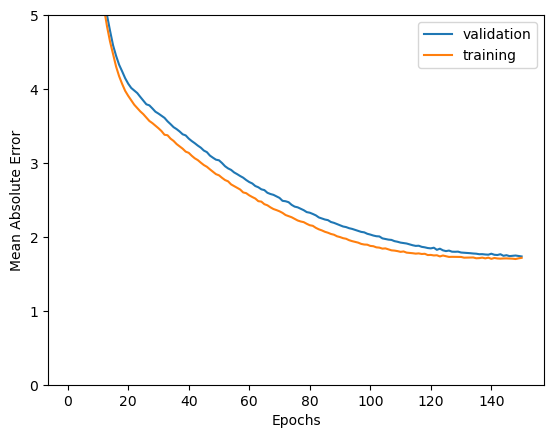

In [15]:
# Recursively run model and save mean MAE for each dropout val
mae_train_means = []
mae_val_means = []
for i in dropout_vals:
    his_train, his_val = k_val_model(train_x, train_y, max_epochs = 150, units = 2, k = 4)
    print("Dropout probability: " + str(i))
    plot_metric(his_train, his_val, num_epochs = 150)
    mae_train_means.append(np.mean(his_train))
    mae_val_means.append(np.mean(his_val))

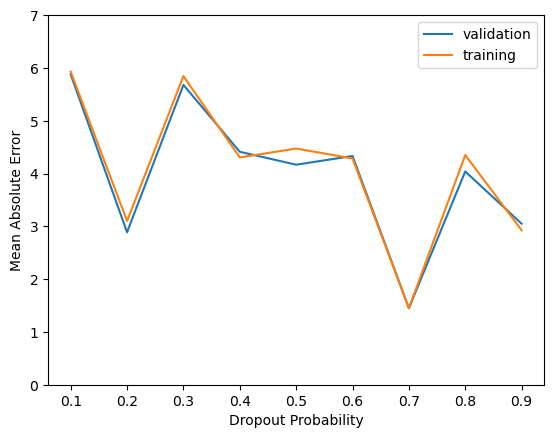

In [16]:
#Plot validation and training scores
upper = max([int(max(mae_train_means) + 2),int(max(mae_val_means) + 2)]) # max value for y-axis (MAE).

plt.plot(range(1, len(mae_val_means)+1), mae_val_means,label = 'validation')
plt.plot(range(1, len(mae_train_means)+1), mae_train_means,label = 'training')
plt.ylim(0,upper)
plt.xlabel('Dropout Probability')
plt.ylabel('Mean Absolute Error')
plt.xticks(range(1, len(mae_train_means)+1), dropout_vals ) # new labels
plt.legend()
plt.show()

#### 0.7 clearly optimal dropout probability value

#### Final model with dropout.

In [19]:
# Ensure early stopping is implemented
es = EarlyStopping(monitor = 'val_loss', patience = 20)

# Build the model
model2 = build_model(train_data = train_x,my_units = 2, dropout = 0.7)
# Fit the model
model2.fit(train_x, train_y, epochs = 150, validation_split = 0.2, verbose = 0, callbacks=[es])

In [20]:
test = model2.evaluate(test_x, test_y, verbose = 0)

print("Mean absolute error on test set for dropout model: " + str(round(test[1],2)))

Mean absolute error on test set for dropout model: 11.11


## Question 4

#### This neural network has two hidden layers and is fit to a training data set, which consists of 175 observations. The model uses three independent variables -- TV, Radio, Newspaper -- to predict sales. The independent varaibles are scaled before the model is fit. The model uses dropout set at 0.7, as this was the optimal value from the set [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9].

#### The input layer has 3 units because, in most cases, the number of units in the input layer should be the same as the number of features in the data (fewer results in loss, more results in overfitting). I decided to include 2 units in each of my hidden layers. This is because it is generally a good rule for the hidden layers to have a number of units that is roughly at the midpoint between the input and output layers. Given that our dataset only has 3 features, it makes sense for the hidden layers to have 2 units each such that the compound features are consolidating information from the input features and not overfitting.

#### The output layer has 1 unit because we are predicting a single value.

#### The model is a STRONG predictor, with the validation set performing almost as well as the training set, in terms of mean absolute error (MAE), across all epochs and most of the dropout trails. For our optimal dropout trail (0.7) the minimum MAE for the validation data is reached at around 80 epochs and decreased very little from there. The mean absolute error achieved on the final model, when evaluated on test data, was 11.11. This reflects a dramatic improvement in performance once the optimal dropout rate was identified. Subsequently, we can conclude that the non-dropout model was performing badly due to overfitting.


#### Again, this model used early stopping to optimize, terminating learning at 20 epochs of no improvement (patience = 20). 
